In [1]:
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
file_path = '20140925_Ketamine02/Charlie_20140925_master_AnticipSacc_behavior.mat'
data = loadmat(file_path)

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'eMat'])


In [2]:
file_path_ = 'timeData.mat/timeData.mat'
columns = loadmat(file_path_)
columnnames = columns['columnNames']

In [4]:
df_n = pd.read_csv("Sample_200.csv")

In [5]:
column_names = [name for name in columns['columnNames'].dtype.names]
trial_data = data['eMat']
df = pd.DataFrame(trial_data, columns=column_names[:trial_data.shape[1]])

In [7]:
df["reaction_time"] = df["time_targ_acq"] - df["time_FP_off"]
df["go_time"] = df["time_FP_off"] - df["time_target_on"]

In [8]:
df = df[df["reaction_time"].notna() & df["go_time"].notna()]

In [9]:
df_n = df_n[df_n["reaction_time"].notna() & df_n["go_time"].notna()]

In [11]:
df.reset_index(drop=True, inplace=True)

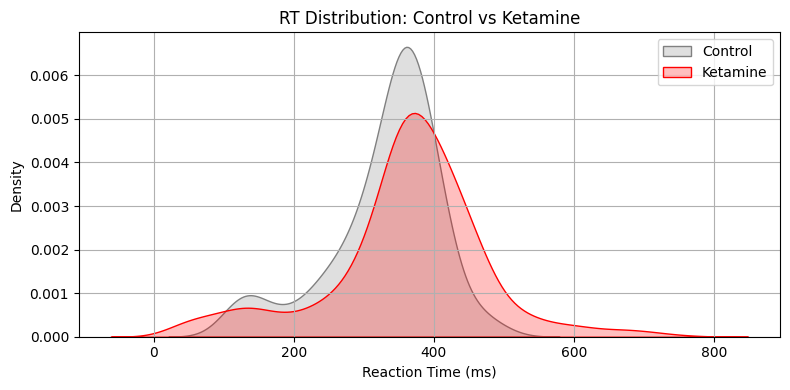

In [14]:
plt.figure(figsize=(8, 4))
sns.kdeplot(df_n["reaction_time"] * 1000,
            label="Control", fill=True, color="gray")
sns.kdeplot(df["reaction_time"] * 1000,
            label="Ketamine", fill=True, color="red")
plt.xlabel("Reaction Time (ms)")
plt.title("RT Distribution: Control vs Ketamine")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
df["reaction_time_ms"] = df["reaction_time"] * 1000
df["rolling_rt"] = df["reaction_time_ms"].rolling(
    window=15, center=True).mean()

In [16]:
df_n["reaction_time_ms"] = df_n["reaction_time"] * 1000
df_n["rolling_rt"] = df_n["reaction_time_ms"].rolling(
    window=15, center=True).mean()

In [17]:
df.reset_index(drop=True, inplace=True)

In [18]:
df_n.shape, df.shape

((161, 46), (845, 46))

In [19]:
df_n.sort_values("go_time", inplace=True)
df.sort_values("go_time", inplace=True)
df_n.reset_index(drop=True, inplace=True)

In [ ]:
def plot_kde(df,df_n, column):
    mean_df = df[column].mean()
    mode_df = df[column].mode()[0]

    mean_df_n = df_n[column].mean()
    mode_df_n = df_n[column].mode()[0]

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.kdeplot(df[column]  , label="Ketamine",
                fill=True, color="red", alpha=0.5)
    plt.axvline(mean_df  , color="blue", linestyle="--",
                label=f"Mean: {mean_df  :.2f} s")
    plt.axvline(mode_df  , color="green", linestyle="--",
                label=f"Mode: {mode_df  :.2f} s")
    plt.axvline(df[column].median()  , color="purple", linestyle="--",
                label=f"Median: {df[column].median()  :.2f} s")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.title("KDE Plot: Ketamine Session")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.kdeplot(df_n[column]  , label="Control",
                fill=True, color="gray", alpha=0.5)
    plt.axvline(mean_df_n  , color="blue", linestyle="--",
                label=f"Mean: {mean_df_n  :.2f} s")
    plt.axvline(mode_df_n  , color="green", linestyle="--",
                label=f"Mode: {mode_df_n  :.2f} s")
    plt.axvline(df_n[column].median()  , color="purple", linestyle="--",
                label=f"Median: {df_n[column].median()  :.2f} s")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.title("KDE Plot: Control Session")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

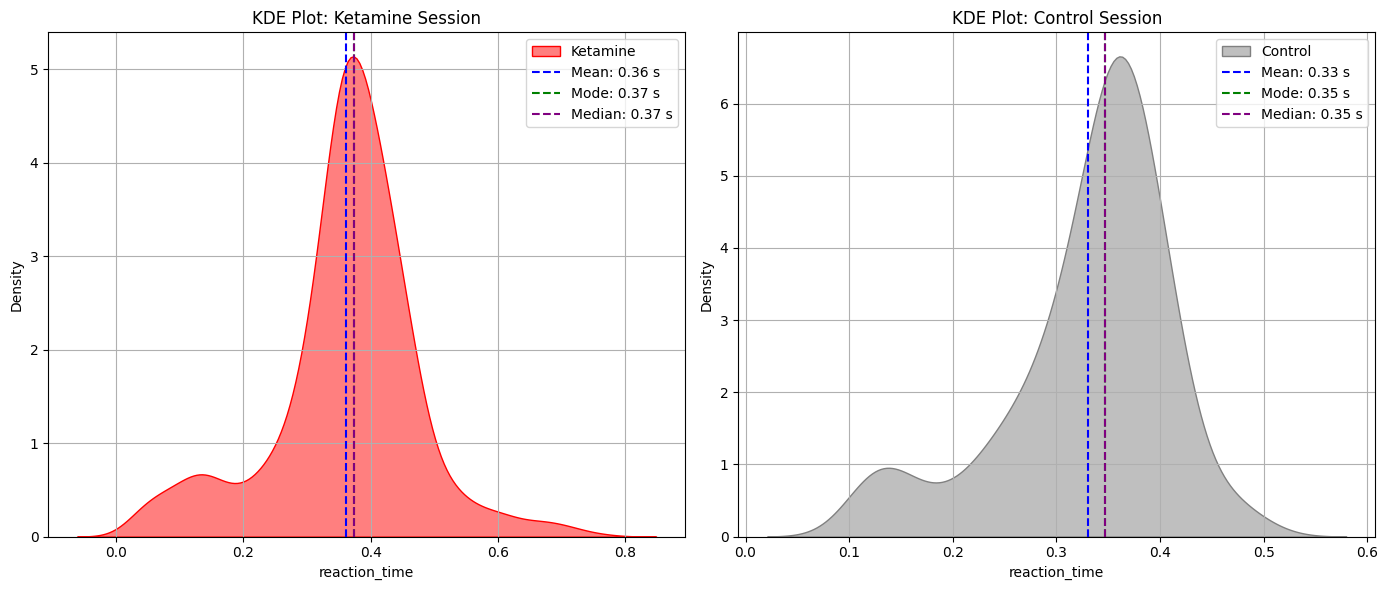

In [57]:
plot_kde(df, df_n, "reaction_time")

In [40]:
from scipy.stats import weibull_min, norm
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import cumtrapz
import numpy as np

#### Probability density function: 

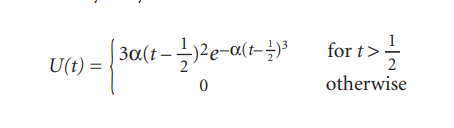

Where the tau in code is the 1/2 in the equation

In [64]:
t_k = df["go_time"].values
t_n = df_n["go_time"].values

def pdf(t,alpha,tau):
    U = np.zeros_like(t)
    valid = t> tau 
    U[valid] = 3 * alpha * (t[valid] -tau) **2 * np.exp(-alpha * (t[valid] -tau)**3)
    return U 

In [88]:
np.percentile(t_k, 25), np.percentile(t_n,25) 

(1.2948999999998705, 1.268175000000042)

In [91]:
np.mean(t_k) ** 2 / np.var(t_k) , np.mean(t_n) ** 2 / np.var(t_n)

(45.992583080886156, 58.96400171139333)

In [105]:
np.mean(t_k), np.mean(t_n)

(1.4387802071005784, 1.3762237577639744)

In [114]:
alpha = 3.0
tau = 1.2

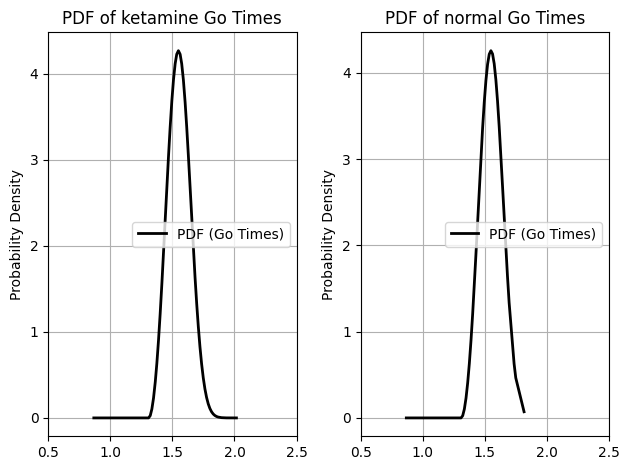

In [131]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(t_k, pdf(t_k,alpha,tau), label="PDF (Go Times)", color="black", lw=2)
axs[0].set_title("PDF of ketamine Go Times")
axs[0].set_ylabel("Probability Density")
axs[0].set_xlim(0.5,2.5)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t_n, pdf(t_n,alpha,tau), label="PDF (Go Times)", color="black", lw=2)
axs[1].set_title("PDF of normal Go Times")
axs[1].set_ylabel("Probability Density")
axs[1].grid(True)
axs[1].set_xlim(0.5,2.5)
axs[1].legend()
plt.tight_layout()

#### Hazard rate

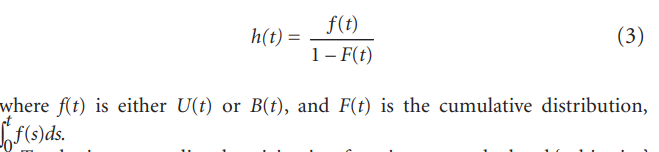

In [116]:
def F_of_t(pdf,t):
    return cumtrapz(pdf,t,initial=0)
def h_of_t(pdf,cdf):
    return np.divide(pdf, (1 - cdf))

In [117]:
hazard_k = h_of_t(pdf(t_k,alpha,tau),F_of_t(pdf(t_k,alpha,tau),t_k))
hazard_n = h_of_t(pdf(t_n,alpha,tau),F_of_t(pdf(t_n,alpha,tau),t_n))

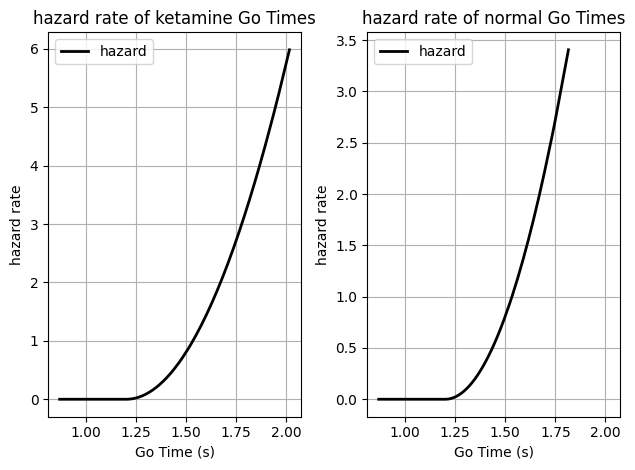

In [118]:
fig, axs = plt.subplots(1, 2,sharex=True) 
axs[0].plot(t_k, hazard_k,label="hazard", color="black", lw=2)
axs[0].set_title("hazard rate of ketamine Go Times")
axs[0].set_ylabel("hazard rate")
axs[0].set_xlabel("Go Time (s)")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t_n, hazard_n,
            label="hazard", color="black", lw=2)
axs[1].set_title("hazard rate of normal Go Times")
axs[1].set_ylabel("hazard rate")
axs[1].set_xlabel("Go Time (s)")
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()

#### Subjective anticipation function/ Hazard rate

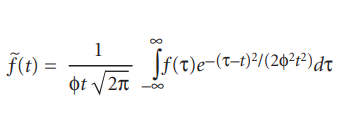

Where the symbol phi is called a weber fraction for time estimation and for most analyses the value is kept 0.26

In [119]:
def subjective_anticipation(t,pdf):
    blurred = np.zeros_like(t)
    for i, ti in enumerate(t):
        sigma = 0.26 * ti 
        kernel = norm.pdf(t - ti, scale=sigma)
        kernel /= np.sum(kernel)
        blurred[i] = np.sum(pdf * kernel) 
    return blurred

In [120]:
subjective_hazard_k = subjective_anticipation(t_k, pdf(t_k,alpha,tau))
subjective_hazard_n = subjective_anticipation(t_n, pdf(t_n,alpha,tau))

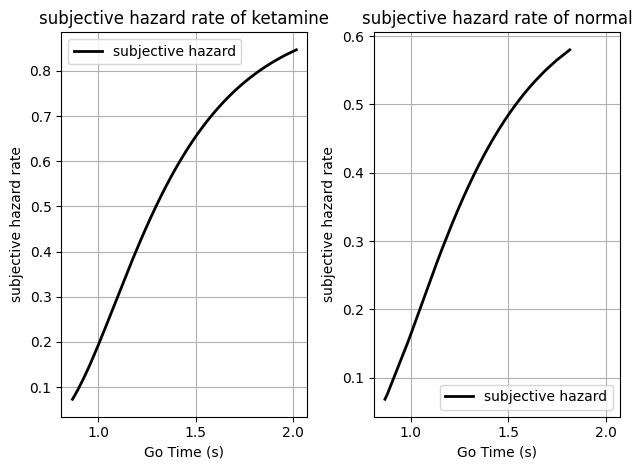

In [121]:
fig, axs = plt.subplots(1, 2, sharex=True)
axs[0].plot(t_k, subjective_hazard_k, label="subjective hazard", color="black", lw=2)
axs[0].set_title("subjective hazard rate of ketamine")
axs[0].set_ylabel("subjective hazard rate")
axs[0].set_xlabel("Go Time (s)")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t_n, subjective_hazard_n,
            label="subjective hazard", color="black", lw=2)
axs[1].set_title("subjective hazard rate of normal")
axs[1].set_ylabel("subjective hazard rate")
axs[1].set_xlabel("Go Time (s)")
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()

In [214]:
df["elapsed_time"] = df["time_target_on"] - df["time_target_on"].min()
df["phase"] = "pre"
df.loc[(df["elapsed_time"] >= 1200) & (
    df["elapsed_time"] <= 3000), "phase"] = "during"
df.loc[df["elapsed_time"] > 3000, "phase"] = "post"

df["reaction_time"] = df["time_targ_acq"] - df["time_FP_off"]
df["go_time"] = df["time_FP_off"] - df["time_target_on"]
df_clean = df[df["reaction_time"].notna() & df["go_time"].notna()].copy()

#### Reaction Time model.

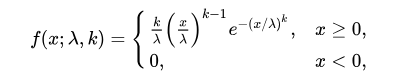

The above equation is the probability density function of a weibull random variable. Where the k is the shape and the λ is the scale parameter of the distribution

Changing the anticipation function to have the same probability density as before (U(t)) where 
- alpha is the scale parameter 
- tau is the time point at which anticipation starts and,
- t is the go time

now RT(t) = baseline - weight x U(t)

In [190]:
def pdf(t, alpha, tau):
    U = np.zeros_like(t)
    valid = t > tau
    U[valid] = 3 * alpha * (t[valid] - tau) ** 2 * \
        np.exp(-alpha * (t[valid] - tau)**3)
    return U

In [191]:
def RT(t, baseline, weight, alpha, tau): 
    anticipation_values = pdf(t, alpha, tau)
    return baseline - weight * anticipation_values

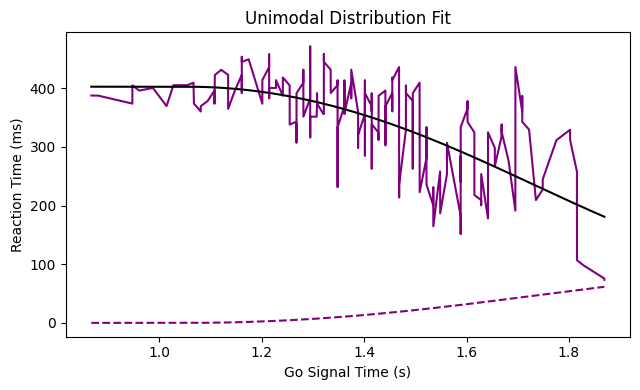

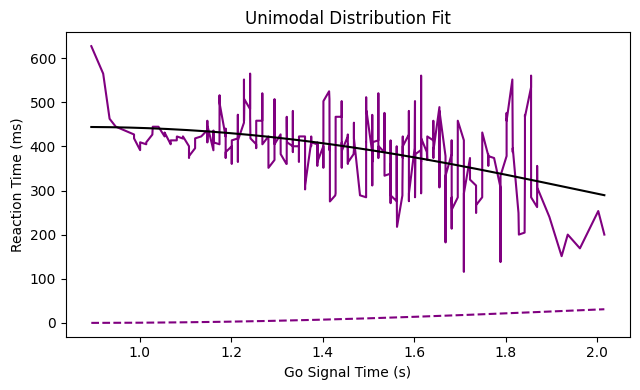

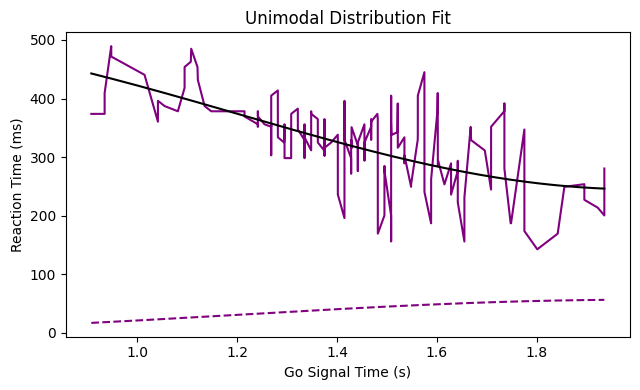

In [228]:
parameters = {}
for phase in df_clean['phase'].unique():
    x = df_clean[df_clean['phase'] == phase]['go_time'].values 

    y = df_clean[df_clean['phase'] == phase]['reaction_time'].values * 1000
    p0 = [np.median(y), np.std(y), 1.0/np.std(x), np.percentile(x, 25)]
    popt, _ = curve_fit(RT, x, y, p0=p0,maxfev=2000, bounds =([0, 0, 0, 0], [np.inf, 500, np.inf, np.inf]))
    x_fit = np.linspace(x.min(), x.max(), 300)
    y_fit = RT(x_fit, *popt)
    hazard_at_go_times = pdf(x, popt[2], popt[3])
    hazard_at_go_times *= 100
    for name, val in zip(["Baseline", "Weight", "Alpha", "Delay"], popt):
        parameters[phase + "_" + name] = val

    plt.figure(figsize=(6.5, 4))

    plt.plot(x, pd.Series(y).rolling(3, center=True, min_periods=1).mean(),
            color='purple')

    plt.plot(x, hazard_at_go_times, 'purple',
            linestyle='--')
    plt.plot(x_fit, y_fit, color='black')

    plt.xlabel("Go Signal Time (s)")
    plt.ylabel("Reaction Time (ms)")
    plt.title("Unimodal Distribution Fit")
    plt.tight_layout()
    plt.show()

In [229]:
for phase in ['pre', 'during', 'post']:
    print(f"Parameters for {phase}:")
    for key, value in parameters.items():
        if key.startswith(phase):
            print(f"  {key.split('_')[1]}: {value}")
    print()

Parameters for pre:
  Baseline: 402.60442363164464
  Weight: 360.3493046156152
  Alpha: 0.37903438857303473
  Delay: 1.0541609830956367

Parameters for during:
  Baseline: 444.146467191088
  Weight: 499.9999998418265
  Alpha: 0.09103463525413202
  Delay: 0.877687295708389

Parameters for post:
  Baseline: 526.0949931926161
  Weight: 499.9999999999202
  Alpha: 0.1096111153217041
  Delay: 0.1809191460609492



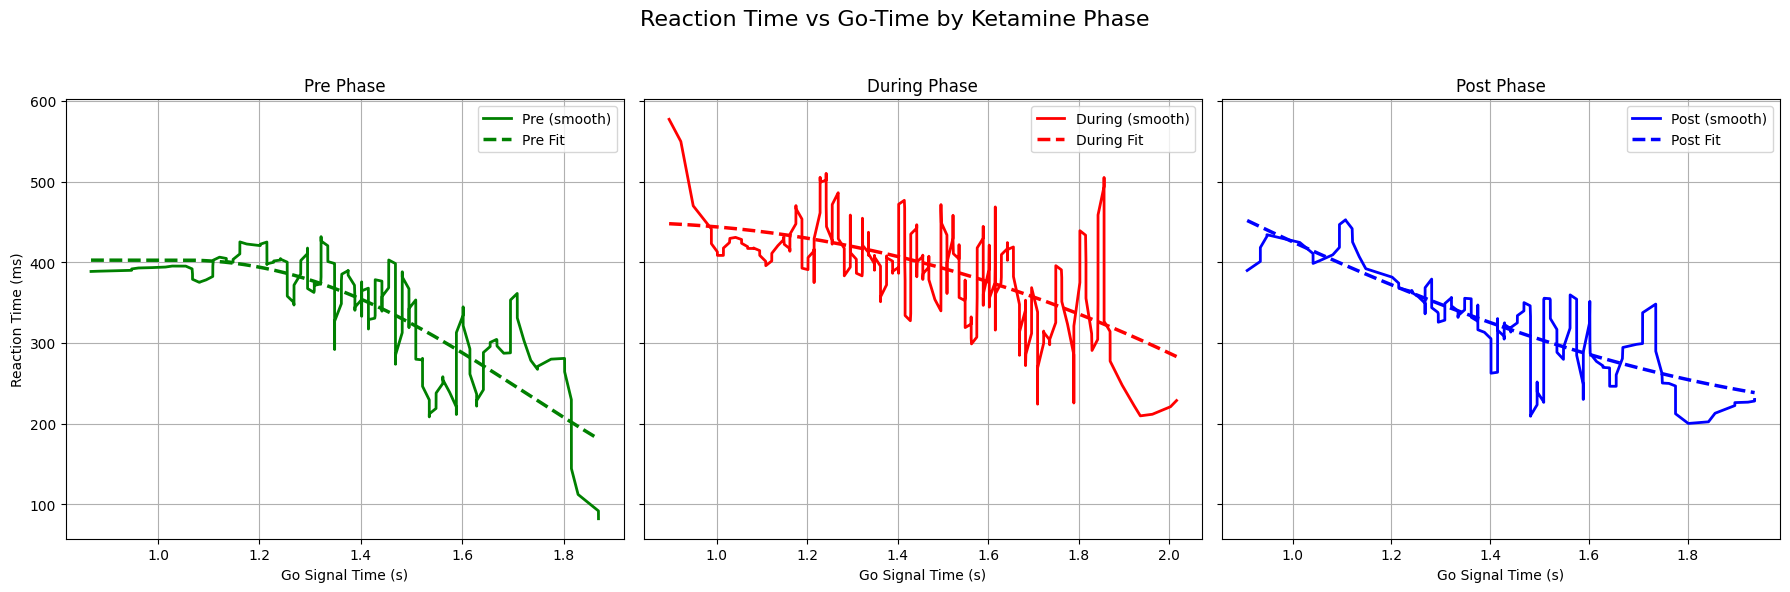

In [230]:
phase_colors = {"pre": "green", "during": "red", "post": "blue"}
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, phase in enumerate(["pre", "during", "post"]):
    ax = axs[i]
    df_phase = df_clean[df_clean["phase"] == phase].copy()
    x = df_phase["go_time"].values
    y = df_phase["reaction_time"].values * 1000
    if len(y) > 10:
        x_sorted_idx = np.argsort(x)
        y_smoothed = gaussian_filter1d(y[x_sorted_idx], sigma=2)
        ax.plot(x[x_sorted_idx], y_smoothed, lw=2,
                color=phase_colors[phase], label=f"{phase.title()} (smooth)")
        try:
            popt, _ = curve_fit(RT, x, y, p0=[np.median(y), np.std(
                y), 1.0/np.std(x), np.percentile(x, 25)], maxfev=10000)
            x_fit = np.linspace(x.min(), x.max(), 300)
            y_fit = RT(x_fit, *popt)
            ax.plot(x_fit, y_fit, lw=2.5,
                    color=phase_colors[phase], linestyle="--", label=f"{phase.title()} Fit")
        except:
            print(f"Could not fit model for phase: {phase}")
    ax.set_title(f"{phase.title()} Phase")
    ax.set_xlabel("Go Signal Time (s)")
    ax.grid(True)
    ax.legend()

axs[0].set_ylabel("Reaction Time (ms)")
fig.suptitle("Reaction Time vs Go-Time by Ketamine Phase", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()